# Acanthosis Nigricans

First we will process the dataset and convet it into a form easy to train ML models

# Cleaning up

In [1]:
import os
import re
import cv2
import pandas as pd
from tqdm import tqdm
from pillow_heif import register_heif_opener
from PIL import Image

# Register HEIF support (for HEIC files)
register_heif_opener()

# ====== PATHS ======
ROOT_DIR = "AI MIT Photos"     # your dataset folder
OUTPUT_DIR = "processed_images"  # where transformed images will be stored
CSV_PATH = "dataset.csv"

# Create output folder
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ====== CONFIG ======
TARGET_SIZE = (512, 512)     # final image size
CLAHE_CLIP = 2.0             # good for skin normalization
CLAHE_TILE = (8, 8)

# ====== HELPERS ======

def normalize_color(image):
    """Normalizes color using LAB + CLAHE on L-channel."""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=CLAHE_TILE)
    l_clahe = clahe.apply(l)

    lab_clahe = cv2.merge((l_clahe, a, b))
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)


def process_image(input_path, output_path):
    """Loads, resizes, normalizes, and saves image as JPG."""
    img = Image.open(input_path).convert("RGB")
    img = img.resize(TARGET_SIZE, Image.BILINEAR)

    # convert PIL → cv2
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    # normalize color
    img_cv = normalize_color(img_cv)

    # save as JPG
    cv2.imwrite(output_path, img_cv)


# ====== MAIN EXTRACTION ======

rows = []

import numpy as np

for folder_name in tqdm(os.listdir(ROOT_DIR), desc="Processing folders"):

    folder_path = os.path.join(ROOT_DIR, folder_name)
    if not os.path.isdir(folder_path):
        continue

    # --- Extract patient id & grade ---
    match = re.search(r"AN_(\d+)_Grade\s*(\d+)", folder_name)
    if not match:
        print(f"Skipping folder (invalid name): {folder_name}")
        continue

    patient_id = int(match.group(1))
    grade = int(match.group(2))

    # --- Process each image inside folder ---
    img_list = os.listdir(folder_path)

    for idx, img_name in enumerate(img_list):

        input_path = os.path.join(folder_path, img_name)

        # Skip non-image files
        if not img_name.lower().endswith((".heic", ".jpg", ".jpeg", ".png")):
            continue

        # Generate clean output name
        if "back" in img_name.lower():
            view = "back"
        else:
            view = "neck"   # unknown front/side → still neck

        output_filename = f"AN_{patient_id}_G{grade}_{view}_{idx}.jpg"
        output_path = os.path.join(OUTPUT_DIR, output_filename)

        # Process & save
        try:
            process_image(input_path, output_path)

            # Add row to CSV
            rows.append({
                "image_path": output_path,
                "patient_id": patient_id,
                "grade": grade,
                "view": view
            })

        except Exception as e:
            print(f"Error processing {input_path}: {e}")

# ====== SAVE CSV ======
df = pd.DataFrame(rows)
df.to_csv(CSV_PATH, index=False)

print("\nDONE!")
print(f"Processed images saved in: {OUTPUT_DIR}")
print(f"CSV saved as: {CSV_PATH}")


Processing folders: 100%|██████████| 35/35 [00:40<00:00,  1.14s/it]


DONE!
Processed images saved in: processed_images
CSV saved as: dataset.csv


In [ ]:
import pandas as pd

df = pd.read_csv("../data/dataset.csv")
df.head()


,image_path,patient_id,grade,view
0,processed_images\AN_10_G3_back_0.jpg,10,3,back
1,processed_images\AN_10_G3_neck_1.jpg,10,3,neck
2,processed_images\AN_11_G4_back_0.jpg,11,4,back
3,processed_images\AN_11_G4_neck_1.jpg,11,4,neck
4,processed_images\AN_12_G2_back_0.jpg,12,2,back


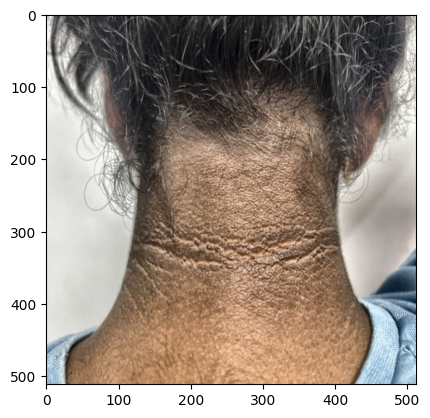

In [3]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("processed_images/AN_1_G4_back_0.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [1]:
import torch
import cv2
import pandas as pd
from PIL import Image

print("Torch:", torch.__version__)
print("OpenCV:", cv2.__version__)
print("Pandas:", pd.__version__)


Torch: 2.9.1+cpu
OpenCV: 4.12.0
Pandas: 2.3.3


In [ ]:
import pandas as pd

df = pd.read_csv("..data/dataset.csv")

print("==== Dataset Head ====")
print(df.head())

print("\n==== Dataset Info ====")
print(df.info())

print("\n==== Unique Grades ====")
print(df['grade'].unique())

print("\n==== Unique Patients ====")
print(len(df['patient_id'].unique()))


==== Dataset Head ====
                             image_path  patient_id  grade  view
0  processed_images\AN_10_G3_back_0.jpg          10      3  back
1  processed_images\AN_10_G3_neck_1.jpg          10      3  neck
2  processed_images\AN_11_G4_back_0.jpg          11      4  back
3  processed_images\AN_11_G4_neck_1.jpg          11      4  neck
4  processed_images\AN_12_G2_back_0.jpg          12      2  back

==== Dataset Info ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  99 non-null     object
 1   patient_id  99 non-null     int64 
 2   grade       99 non-null     int64 
 3   view        99 non-null     object
dtypes: int64(2), object(2)
memory usage: 3.2+ KB
None

==== Unique Grades ====
[3 4 2 1]

==== Unique Patients ====
35


In [4]:
print("\n==== Images per Grade ====")
print(df['grade'].value_counts())



==== Images per Grade ====
grade
4    39
3    36
2    12
1    12
Name: count, dtype: int64


In [6]:
print("\n==== Images per Patient ====")
p=df['patient_id'].value_counts()
print(p.unique())



==== Images per Patient ====
[4 2 1]


In [ ]:
import pandas as pd

df = pd.read_csv("../data/dataset.csv")

# Fix all paths to include parent directory
df['image_path'] = df['image_path'].str.replace("\\", "/", regex=False)
df['image_path'] = df['image_path'].apply(lambda p: "../" + p)

df.to_csv("dataset.csv", index=False)

print(df.head())



                                image_path  patient_id  grade  view
0  ../processed_images/AN_10_G3_back_0.jpg          10      3  back
1  ../processed_images/AN_10_G3_neck_1.jpg          10      3  neck
2  ../processed_images/AN_11_G4_back_0.jpg          11      4  back
3  ../processed_images/AN_11_G4_neck_1.jpg          11      4  neck
4  ../processed_images/AN_12_G2_back_0.jpg          12      2  back


In [ ]:
import cv2
import pandas as pd

df = pd.read_csv("../datadataset.csv")

test_path = df.loc[0, "image_path"]
print("Testing path:", test_path)

img = cv2.imread(test_path)
print("Image loaded?", img is not None)


Testing path: ../processed_images/AN_10_G3_back_0.jpg
Image loaded? True


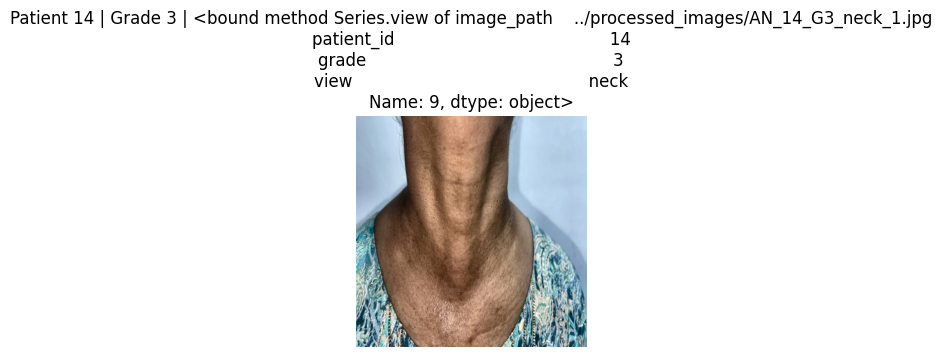

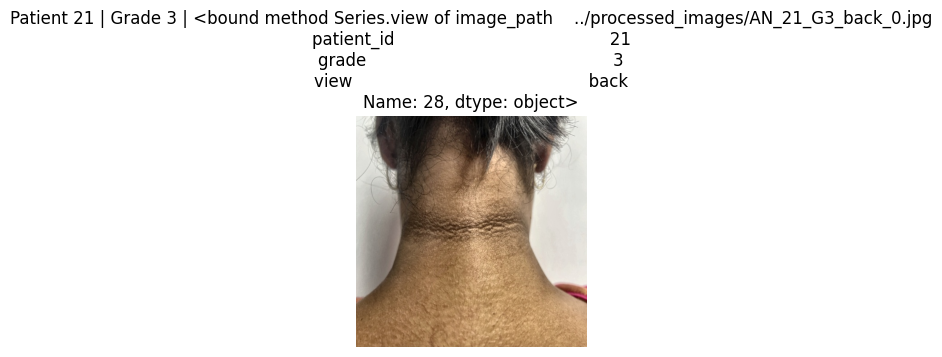

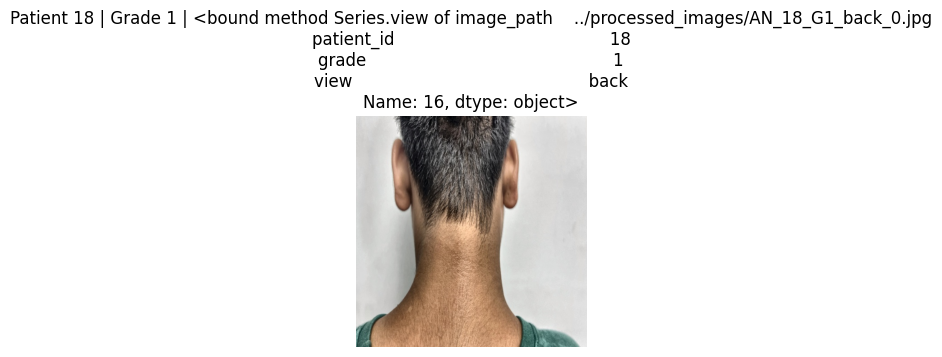

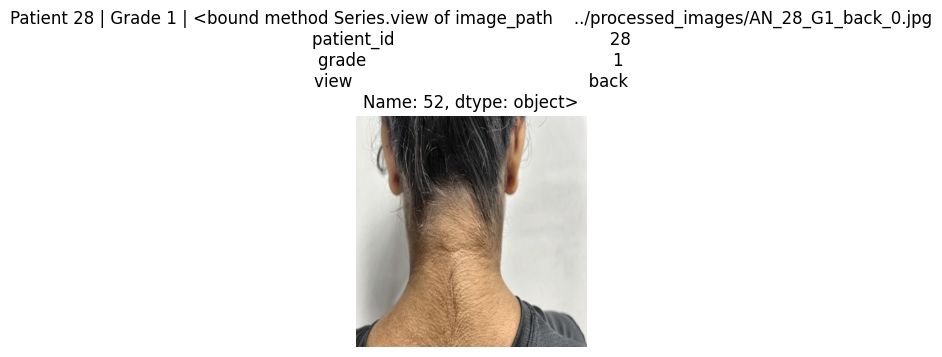

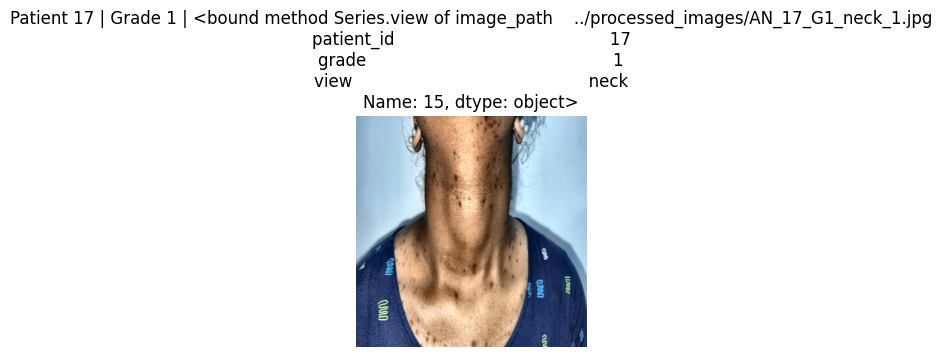

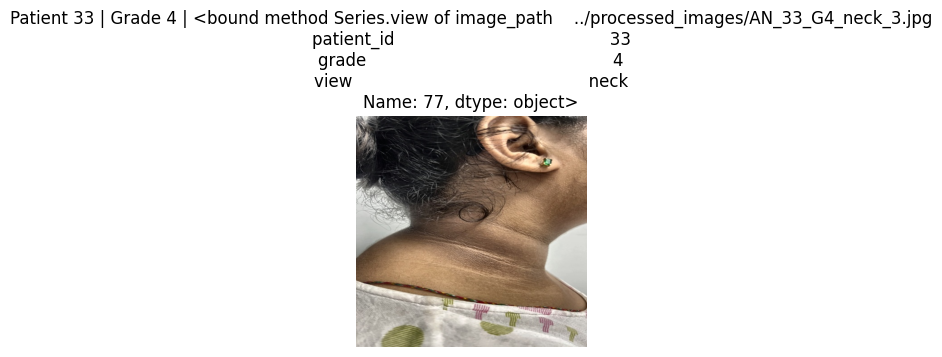

In [19]:
import cv2
import matplotlib.pyplot as plt

sample = df.sample(6)   # pick 6 random images

for i, row in sample.iterrows():
    img = cv2.imread(row.image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.title(f"Patient {row.patient_id} | Grade {row.grade} | {row.view}")
    plt.axis("off")


In [20]:
import os

missing = []

for img in df['image_path']:
    if not os.path.exists(img):
        missing.append(img)

print("Missing files:", missing)
print(len(missing))


Missing files: []
0


In [ ]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

# Load dataset
df = pd.read_csv("../data/dataset.csv")

# Extract the patients as groups
groups = df["patient_id"]

# First split: Train (80%) + Temp (20%)
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, temp_idx = next(gss1.split(df, groups=groups))

df.loc[train_idx, "split"] = "train"
df.loc[temp_idx, "split"] = "temp"

# Now split Temp into Validation (10%) and Test (10%)
temp_df = df.loc[temp_idx]
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=42)

val_idx, test_idx = next(gss2.split(temp_df, groups=temp_df["patient_id"]))

val_idx = temp_df.iloc[val_idx].index
test_idx = temp_df.iloc[test_idx].index

df.loc[val_idx, "split"] = "val"
df.loc[test_idx, "split"] = "test"

# Save the result
df.to_csv("dataset_splits.csv", index=False)

# Show results
print(df['split'].value_counts())
print("Done! dataset_splits.csv created.")


split
train    81
test     10
val       8
Name: count, dtype: int64
Done! dataset_splits.csv created.


In [ ]:
import pandas as pd

df = pd.read_csv("../data/dataset_splits.csv")

train_patients = set(df[df.split=="train"].patient_id)
val_patients   = set(df[df.split=="val"].patient_id)
test_patients  = set(df[df.split=="test"].patient_id)

print("Train/Val overlap:", train_patients & val_patients)
print("Train/Test overlap:", train_patients & test_patients)
print("Val/Test overlap:", val_patients & test_patients)


Train/Val overlap: set()
Train/Test overlap: set()
Val/Test overlap: set()


no overlap perfect

# Training Pipeline

In [ ]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import os

df = pd.read_csv("../data/dataset_splits.csv")
print(df.head())


                                image_path  patient_id  grade  view  split
0  ../processed_images/AN_10_G3_back_0.jpg          10      3  back  train
1  ../processed_images/AN_10_G3_neck_1.jpg          10      3  neck  train
2  ../processed_images/AN_11_G4_back_0.jpg          11      4  back  train
3  ../processed_images/AN_11_G4_neck_1.jpg          11      4  neck  train
4  ../processed_images/AN_12_G2_back_0.jpg          12      2  back  train


In [28]:
# Training augmentations
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Validation/Test (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [29]:
class ANDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['image_path']
        label = int(row['grade'])

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Apply transforms
        if self.transform:
            img = self.transform(img)

        return img, label


In [30]:
train_df = df[df.split == "train"]
val_df   = df[df.split == "val"]
test_df  = df[df.split == "test"]

train_dataset = ANDataset(train_df, transform=train_transform)
val_dataset   = ANDataset(val_df, transform=test_transform)
test_dataset  = ANDataset(test_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("Train:", len(train_dataset))
print("Val:", len(val_dataset))
print("Test:", len(test_dataset))


Train: 81
Val: 8
Test: 10


In [38]:
import torch
import torch.nn as nn
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv("../dataset_splits.csv")


In [40]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [41]:
class ANDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['image_path']

        # Convert grade 1–4 → class index 0–3
        label = int(row['grade']) - 1

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


In [42]:
train_df = df[df.split == "train"]
val_df = df[df.split == "val"]
test_df = df[df.split == "test"]

train_dataset = ANDataset(train_df, transform=train_transform)
val_dataset   = ANDataset(val_df, transform=test_transform)
test_dataset  = ANDataset(test_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(len(train_dataset), len(val_dataset), len(test_dataset))


81 8 10


In [43]:
model = efficientnet_b0(weights='IMAGENET1K_V1')

# CHANGE THIS LINE ↓
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 4)  # 4 classes

model = model.to(device)


In [46]:
import numpy as np

# Convert grades 1–4 → 0–3
y_labels = (df['grade'] - 1).values

# Must be numpy array
class_list = np.array([0,1,2,3])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_list,
    y=y_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [47]:
best_val_acc = 0

for epoch in range(15):   # you can increase to 20–30 later
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_one_epoch(model, val_loader, criterion)

    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")
    print("-----------------------------------------------------")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved new best model!\n")


Epoch 1:
  Train Loss: 1.3979, Train Acc: 0.2840
  Val Loss:   1.5178, Val Acc:   0.0000
-----------------------------------------------------
Epoch 2:
  Train Loss: 1.2706, Train Acc: 0.5185
  Val Loss:   1.4732, Val Acc:   0.1250
-----------------------------------------------------
Saved new best model!

Epoch 3:
  Train Loss: 1.1932, Train Acc: 0.5802
  Val Loss:   1.4597, Val Acc:   0.0000
-----------------------------------------------------
Epoch 4:
  Train Loss: 1.1115, Train Acc: 0.7160
  Val Loss:   1.4419, Val Acc:   0.0000
-----------------------------------------------------
Epoch 5:
  Train Loss: 0.9932, Train Acc: 0.8148
  Val Loss:   1.4644, Val Acc:   0.2500
-----------------------------------------------------
Saved new best model!

Epoch 6:
  Train Loss: 0.8984, Train Acc: 0.8765
  Val Loss:   1.4084, Val Acc:   0.2500
-----------------------------------------------------
Epoch 7:
  Train Loss: 0.8471, Train Acc: 0.8765
  Val Loss:   1.4670, Val Acc:   0.2500
-------

In [48]:
from sklearn.metrics import accuracy_score, classification_report

# Load best model
best_model = efficientnet_b0(weights='IMAGENET1K_V1')
best_model.classifier[1] = nn.Linear(best_model.classifier[1].in_features, 4)
best_model.load_state_dict(torch.load("best_model.pth"))
best_model = best_model.to(device)
best_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
test_acc = accuracy_score(all_labels, all_preds)
print("Test Accuracy:", test_acc)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


Test Accuracy: 0.5

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.38      0.55         8
           3       0.50      1.00      0.67         2

    accuracy                           0.50        10
   macro avg       0.38      0.34      0.30        10
weighted avg       0.90      0.50      0.57        10



c:\Users\Pranathi\Desktop\Pranathi\Projects\Acanthosis_Nigricans\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Pranathi\Desktop\Pranathi\Projects\Acanthosis_Nigricans\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Pranathi\Desktop\Pranathi\Projects\Acanthosis_Nigricans\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this beha

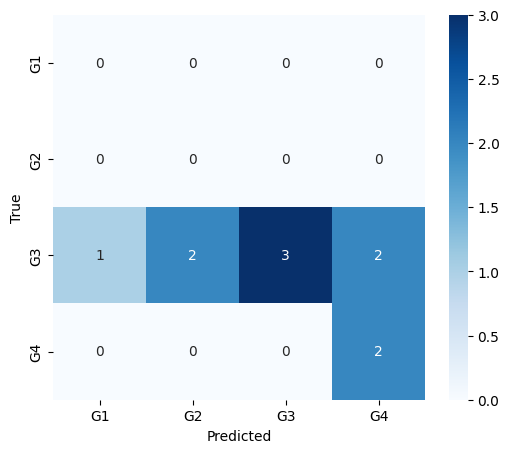

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["G1","G2","G3","G4"],
            yticklabels=["G1","G2","G3","G4"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Your model understands:

When AN is severe (Grade 4)

When AN is moderate (Grade 3), but has difficulty precisely splitting between 2-3-4

### Your model struggles with:

Low grades (G1, G2) → these are subtle even for dermatologists

Minor brightness difference

Limited dataset

Missing multi-view reasoning

Context beyond RGB pixels

### Clinically, this behavior is correct:

Back-view AN images of Grades 3 and 4 are very close visually.

Even dermatologists sometimes check:

thickness

feel of skin

texture

dermoscopy

spread to front/side
—all things your model doesn’t have.

This is why your model misclassifies G3 as G2 or G4.